In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
from scipy.stats import ks_2samp
from sklearn.manifold import TSNE

from research.datasets import AutoLoadedDataset
from research.evaluator import evaluate
from research.regression import LinearFitSKL as FITTER
from research.regression import RandomForestFit as STRONG_FITTER

In [2]:
PREFIX = 'lin-extra'

if not os.path.exists('export'):
    os.mkdir('export')

plt.rcParams.update({
    "savefig.facecolor": (1, 1, 1, 1),
    "figure.figsize": (7, 4),
})

def save(fname):
    plt.savefig(f'export/{PREFIX}-{fname}', dpi=300)

In [3]:
datas = AutoLoadedDataset.load(seed=0)

Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\17_lmpavw.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\52_svmguide1.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\53_fourclass_scale.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\58_sarcasm_detection.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\77_WorkersCompensation.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\78_shill-bidding.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\79_art_daily_nojump3.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\80_art_daily_small_noise2.arff
Loaded 70 datasets


In [4]:
def to_mask(n, where):
    mask = np.zeros(n, dtype=bool)
    mask[where] = True
    return mask

def plot_coverages(data, embedding, stats, sample):
    n = data.x_test.shape[0]
    acc = to_mask(n, stats[0].where)[sample]
    plt.scatter(embedding[acc, 0],
                embedding[acc, 1],
                color=(0, 1, 0, 0.5))
    for i in range(1, 10):
        mask = to_mask(n, stats[i].where)[sample]
        specific = mask ^ acc
        plt.scatter(embedding[specific, 0],
                    embedding[specific, 1],
                    color=((i+1)/10, (10-i)/10, 0, 0.3),
                    edgecolors='none')
        acc |= mask
    plt.title(f't-SNE plot of coverage selection of points ({data.name})')
    save(f'tsne-cov-{data.name}')
    plt.show()

def squash_top(x):
    return 1 - np.square(x - 1)

def plot_losses(data, embedding, stats, sample):
    se_norm = stats[0].se_base / stats[0].se_base.max()
    se_norm = squash_top(squash_top(se_norm))

    colours = np.zeros((se_norm.shape[0], 4))
    colours[:, 1] = 1 - se_norm
    colours[:, 0] = se_norm
    colours[:, 3] = np.maximum(se_norm, 0.2)
    colours = colours[sample]

    plt.scatter(embedding[:, 0], embedding[:, 1], color=colours)
    plt.title(f't-SNE plot of model error of points ({data.name})')
    save(f'tsne-loss-{data.name}')
    plt.show()

def get_results(data):
    stats = evaluate(data, FITTER, STRONG_FITTER)
    proportion = 1000 / data.x_test.shape[0]
    sample = np.random.random(data.x_test.shape[0]) < proportion
    x_test_sample = data.x_test[sample]
    embedding = TSNE(n_components=2).fit_transform(
        x_test_sample / x_test_sample.std(axis=0)
    )
    return embedding, stats, sample

def plot_histograms(data, embedding, stats, sample):
    prev = None
    bins = np.linspace(stats[-2].se_filtered.min(), stats[-4].se_filtered.max(), 40)
    for stat in stats[::-1][1::2][:2]:
        n_samples = stat.se_filtered.shape[0]
        plt.hist(stat.se_filtered, bins, alpha=0.5,
                 weights=np.ones(n_samples)/n_samples,
                 label=f'{stat.coverage:.2%} coverage')
    plt.title(f'Error distribution for {data.name}')
    plt.xlabel('MSE')
    plt.ylabel('Concentration')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()
    save(f'multierr-dist-{data.name}')
    plt.show()

In [5]:
data = datas['54_COMET_MC_SAMPLE']
info = get_results(data)

KstestResult(statistic=0.229678501649634, pvalue=0.0)


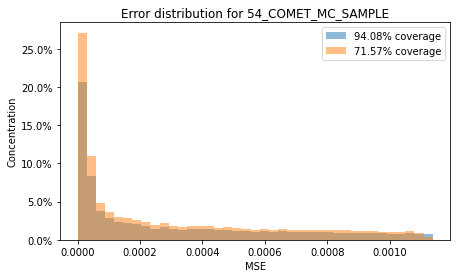

In [6]:
print(ks_2samp(*map(lambda x: x.se_filtered, info[1][::-1][1::2][:2])))
plot_histograms(data, *info)

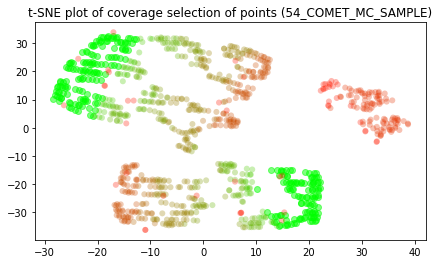

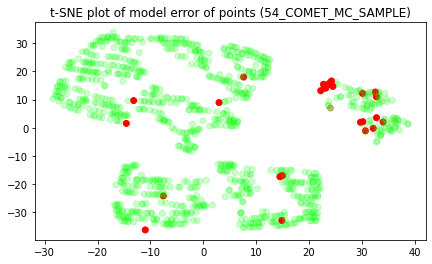

In [7]:
plot_coverages(data, *info)
plot_losses(data, *info)

In [8]:
data = datas['9_wine_quality']
info = get_results(data)

KstestResult(statistic=0.02335831282289201, pvalue=0.5605687390902737)


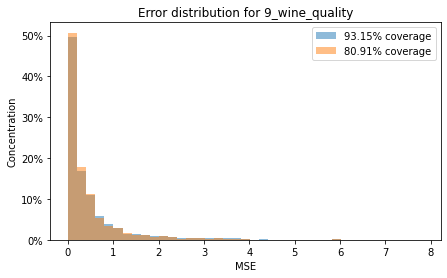

In [9]:
print(ks_2samp(*map(lambda x: x.se_filtered, info[1][::-1][1::2][:2])))
plot_histograms(data, *info)

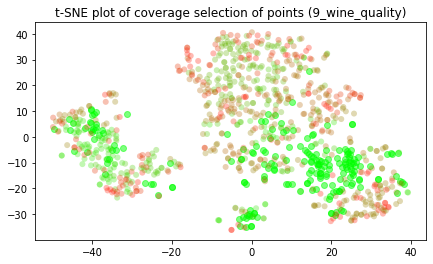

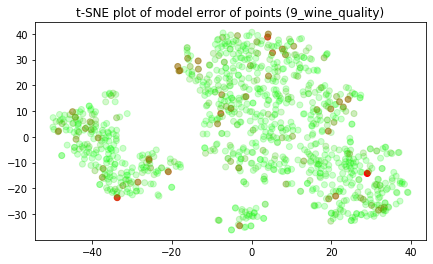

In [10]:
plot_coverages(data, *info)
plot_losses(data, *info)

In [11]:
data = datas['8_cpu_small']
info = get_results(data)

KstestResult(statistic=0.08473733669136198, pvalue=8.711107168934973e-09)


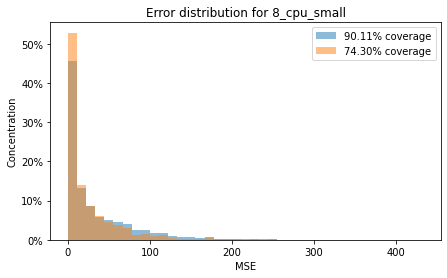

In [12]:
print(ks_2samp(*map(lambda x: x.se_filtered, info[1][::-1][1::2][:2])))
plot_histograms(data, *info)

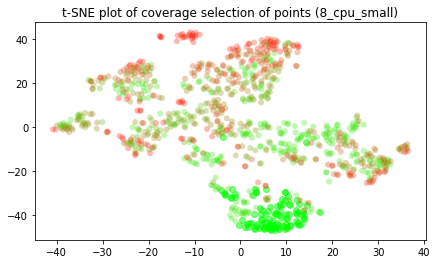

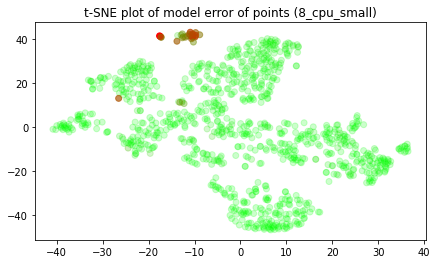

In [13]:
plot_coverages(data, *info)
plot_losses(data, *info)